## 导入及预处理

In [1]:
import pandas as pd
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
df = df[["text","sentiment"]]
test = test[["text","sentiment"]]
test['sentiment'].replace(["positive","neutral","negative"], [2,1,0], inplace=True)
df['sentiment'].replace(["positive","neutral","negative"], [2,1,0], inplace=True)

In [3]:
import string
import re
def process_raw_text(x):
    x = str(x).lower()
    x = re.sub('\[.*?\]', '', x)
    x = re.sub('https?://\S+|www\.\S+', '', x)
    x = re.sub('<.*?>+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x)
    x = re.sub('\n', '', x)
    x = re.sub('\w*\d\w*', '', x)
    x = x.strip()
    return x
df["text"] = df['text'].apply(lambda x:process_raw_text(x))
test["text"] = test['text'].apply(lambda x:process_raw_text(x))
df.dropna(inplace = True)
test.dropna(inplace = True)

## 向量化

In [4]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 9000) 
tokenizer.fit_on_texts(df.text.values)
X_train = tokenizer.texts_to_sequences(df.text)
X_test =  tokenizer.texts_to_sequences(test.text)

In [5]:
import numpy as np
y_train = np.asarray(df.sentiment.tolist())
y_test = np.asarray(test.sentiment.tolist())

In [6]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [7]:
from keras import preprocessing
maxlen = 25
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

# 预训练处理

In [8]:
import os
glove_dir = 'D:\Jupyter\projects\DL Projects\smmtwitter'

embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'), encoding="UTF-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [9]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((9000,100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < 9000:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 训练

In [10]:
from keras.layers import *
from keras.models import  *

### 最终模型结构

In [27]:
model = Sequential()
model.add(Embedding(9000, 100, input_length=maxlen))
model.add(GRU(32, dropout=0.2,recurrent_dropout=0.2,return_sequences =True))
model.add(GRU(128, dropout=0.2,recurrent_dropout=0.2,return_sequences = False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 100)           900000    
                                                                 
 gru_9 (GRU)                 (None, 25, 32)            12864     
                                                                 
 gru_10 (GRU)                (None, 128)               62208     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)               

In [28]:
history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data = (X_test,y_test))

Epoch 1/40
430/430 [==============================] - 24s 47ms/step - loss: 0.8955 - accuracy: 0.5805 - val_loss: 0.7366 - val_accuracy: 0.6752
Epoch 2/40
430/430 [==============================] - 21s 48ms/step - loss: 0.7609 - accuracy: 0.6750 - val_loss: 0.6952 - val_accuracy: 0.7015
Epoch 3/40
430/430 [==============================] - 23s 53ms/step - loss: 0.7299 - accuracy: 0.6930 - val_loss: 0.6812 - val_accuracy: 0.7080
Epoch 4/40
430/430 [==============================] - 19s 44ms/step - loss: 0.7157 - accuracy: 0.7001 - val_loss: 0.6703 - val_accuracy: 0.7190
Epoch 5/40
430/430 [==============================] - 17s 40ms/step - loss: 0.7019 - accuracy: 0.7051 - val_loss: 0.6630 - val_accuracy: 0.7227
Epoch 6/40
430/430 [==============================] - 20s 46ms/step - loss: 0.6902 - accuracy: 0.7114 - val_loss: 0.6486 - val_accuracy: 0.7281
Epoch 7/40
430/430 [==============================] - 18s 42ms/step - loss: 0.6784 - accuracy: 0.7167 - val_loss: 0.6567 - val_accuracy:

In [29]:
val_acc = history.history['val_accuracy']

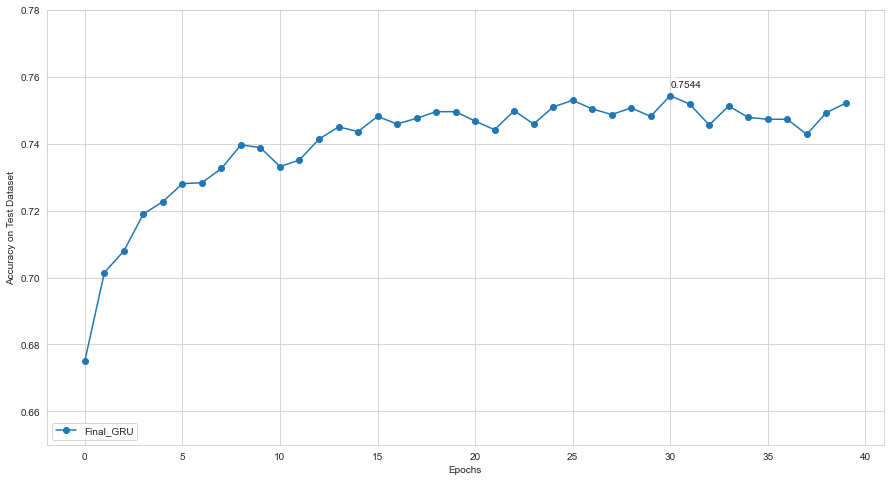

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize = (15,8))
epochs = range(40)
plt.ylim(0.65,0.78)
plt.plot(epochs, val_acc, marker='o',label="Final_GRU")
plt.annotate("0.7544",
            xy=(30, 0.76), xycoords='data',
            xytext=(30, 0.757), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.xlabel("Epochs")
plt.ylabel("Accuracy on Test Dataset")
plt.legend(loc = "lower left")

## 模型结构可视化

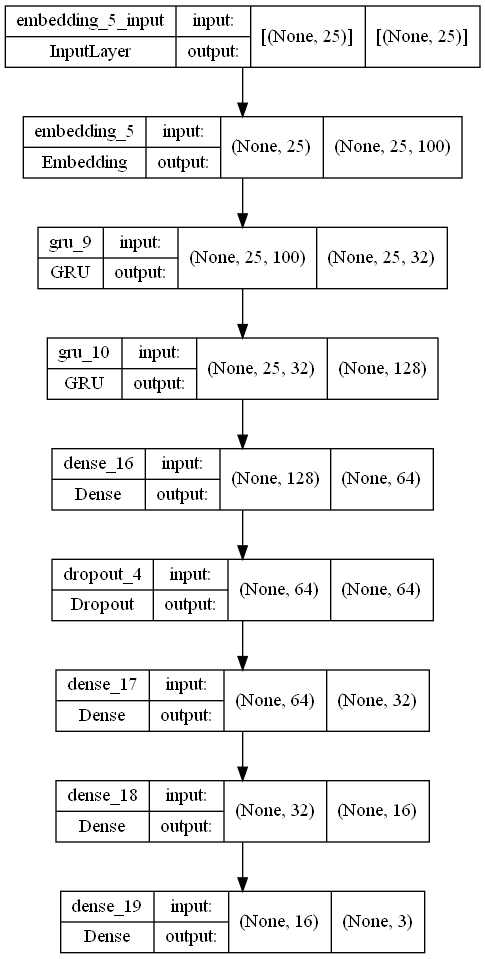

In [33]:
import pydot
from keras.utils.vis_utils import plot_model
from keras.models import load_model
plot_model(model,show_shapes=True)

## CNN + GRU层叠模型

In [20]:
model = Sequential()
model.add(Embedding(9000, 100, input_length=maxlen))
model.add(Conv1D(32, 2, activation='relu'))
model.add(AveragePooling1D(2))
model.add(Conv1D(32, 2, activation='relu'))
model.add(GRU(32, dropout=0.2,recurrent_dropout=0.2,return_sequences =True))
model.add(GRU(128, dropout=0.2,recurrent_dropout=0.2,return_sequences = False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 100)           900000    
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 32)            6432      
                                                                 
 average_pooling1d_1 (Averag  (None, 12, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 32)            2080      
                                                                 
 gru_5 (GRU)                 (None, 11, 32)            6336      
                                                                 
 gru_6 (GRU)                 (None, 128)               62208     
                                                      

In [22]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data = (X_test,y_test))

Epoch 1/20
430/430 [==============================] - 11s 19ms/step - loss: 0.9293 - accuracy: 0.5485 - val_loss: 0.7596 - val_accuracy: 0.6658
Epoch 2/20
430/430 [==============================] - 7s 17ms/step - loss: 0.7545 - accuracy: 0.6776 - val_loss: 0.7131 - val_accuracy: 0.6969
Epoch 3/20
430/430 [==============================] - 7s 17ms/step - loss: 0.7158 - accuracy: 0.6981 - val_loss: 0.6905 - val_accuracy: 0.7094
Epoch 4/20
430/430 [==============================] - 7s 17ms/step - loss: 0.6917 - accuracy: 0.7104 - val_loss: 0.6852 - val_accuracy: 0.7105
Epoch 5/20
430/430 [==============================] - 7s 17ms/step - loss: 0.6765 - accuracy: 0.7197 - val_loss: 0.6754 - val_accuracy: 0.7184
Epoch 6/20
430/430 [==============================] - 8s 18ms/step - loss: 0.6606 - accuracy: 0.7268 - val_loss: 0.6777 - val_accuracy: 0.7210
Epoch 7/20
430/430 [==============================] - 8s 18ms/step - loss: 0.6454 - accuracy: 0.7361 - val_loss: 0.6623 - val_accuracy: 0.727

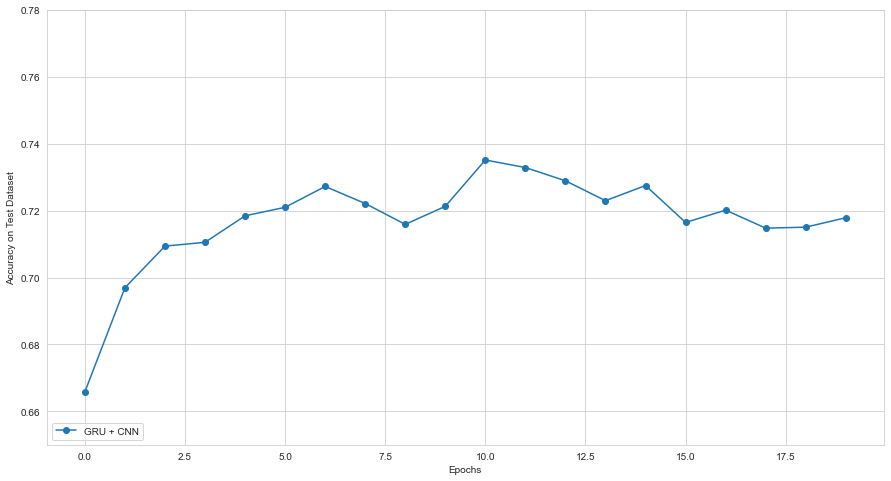

In [24]:
val_acc = history.history['val_accuracy']
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize = (15,8))
epochs = range(20)
plt.ylim(0.65,0.78)
plt.plot(epochs, val_acc, marker='o',label="GRU + CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Test Dataset")
plt.legend(loc = "lower left")

## GRU+CNN结合模型

### 模型结构

In [12]:
input_text = Input(shape = (None,))
embedded = Embedding(9000,100,input_length = 25)(input_text)
gru1 = GRU(32, dropout=0.2,recurrent_dropout=0.2,return_sequences = True)(embedded)
gru2 = GRU(128, dropout=0.2,recurrent_dropout=0.2,return_sequences = True)(gru1)
mp = GlobalMaxPool1D()(gru2)
ba1 = BatchNormalization()(mp)
den1 = Dense(64, activation='relu')(ba1)
dro1 = Dropout(0.2)(den1)
den2 = Dense(32, activation='relu')(dro1)
dro2 = Dropout(0.2)(den2)
den3 = Dense(16, activation='relu')(dro2)
dro3 = Dropout(0.2)(den3)


c1 = Conv1D(32, 2, activation='relu')(embedded)
ba = BatchNormalization()(c1)
pool1= AveragePooling1D(2)(ba)
c2 = Conv1D(32, 2, activation='relu')(pool1)
pool2 = GlobalAveragePooling1D()(c2)
cden1 = Dense(64, activation='relu')(pool2)
cdro1 = Dropout(0.2)(cden1)
cden2 = Dense(32, activation='relu')(cdro1)
cdro2 = Dropout(0.2)(cden2)
cden3 = Dense(16, activation='relu')(cdro2)

con = concatenate([cden3,dro3])
con2 = Dense(32,activation='relu')(con)
dro4 =Dropout(0.1)(con2)
con3 = Dense(16,activation='relu')(dro4)
finn = Dense(3,activation='softmax')(con2)


model = Model(input_text,finn)
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

### 训练结果

In [14]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data = (X_test,y_test))

Epoch 1/20
430/430 [==============================] - 19s 36ms/step - loss: 0.8485 - accuracy: 0.6184 - val_loss: 0.7518 - val_accuracy: 0.6653
Epoch 2/20
430/430 [==============================] - 15s 36ms/step - loss: 0.7539 - accuracy: 0.6783 - val_loss: 0.7323 - val_accuracy: 0.6839
Epoch 3/20
430/430 [==============================] - 17s 40ms/step - loss: 0.7107 - accuracy: 0.7021 - val_loss: 0.6905 - val_accuracy: 0.7015
Epoch 4/20
430/430 [==============================] - 17s 39ms/step - loss: 0.6839 - accuracy: 0.7167 - val_loss: 0.6882 - val_accuracy: 0.7032
Epoch 5/20
430/430 [==============================] - 17s 39ms/step - loss: 0.6636 - accuracy: 0.7269 - val_loss: 0.6834 - val_accuracy: 0.7105
Epoch 6/20
430/430 [==============================] - 16s 37ms/step - loss: 0.6474 - accuracy: 0.7318 - val_loss: 0.6714 - val_accuracy: 0.7083
Epoch 7/20
430/430 [==============================] - 16s 38ms/step - loss: 0.6366 - accuracy: 0.7420 - val_loss: 0.6773 - val_accuracy:

### 模型可视化

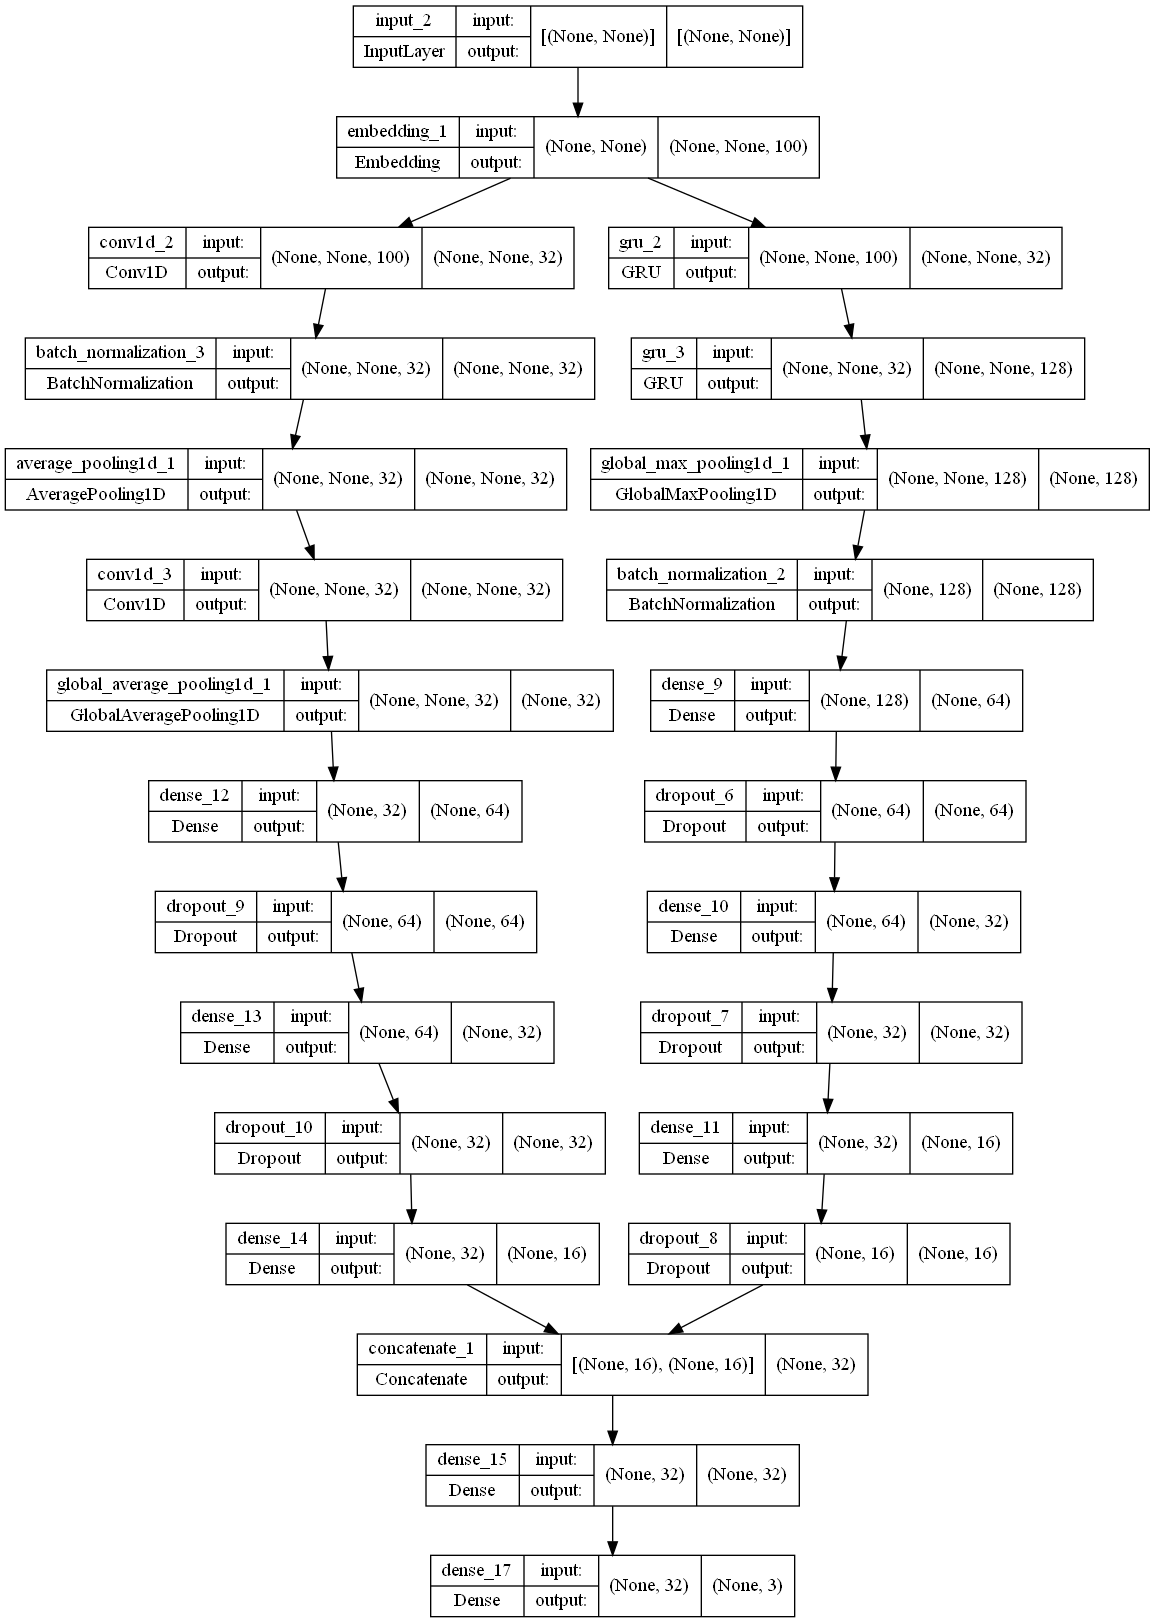

In [15]:
plot_model(model,to_file="model.png",show_shapes=True)

### 训练结果可视化

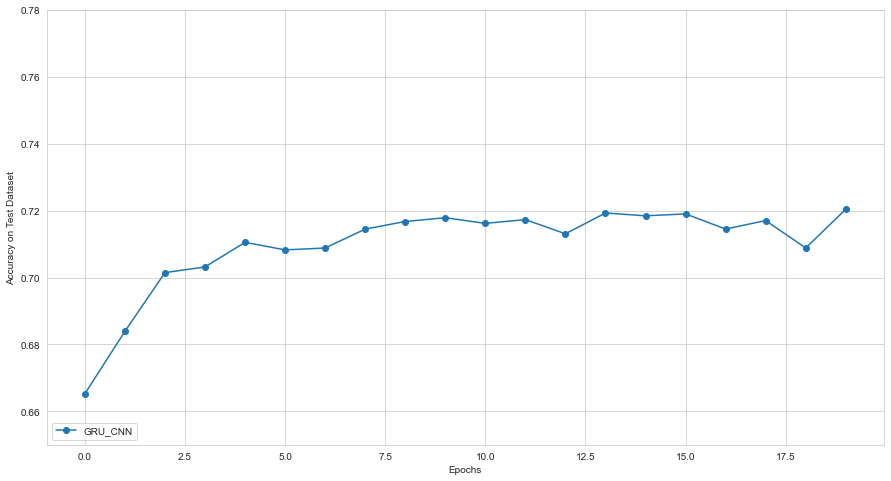

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize = (15,8))
epochs = range(20)
plt.ylim(0.65,0.78)
plt.plot(epochs, val_gru2, marker='o',label = "GRU_CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Test Dataset")
plt.legend(loc = "lower left")